In [47]:
import steps.model as smodel
import steps.geom as swm
import steps.rng as srng
import steps.solver as ssolver
import numpy as np
import matplotlib.pyplot as plt


####################################################################################################################################
# instantiate the model:
mdl = smodel.Model()

####################################################################################################################################
# instantiate SPECIES (HERE ONLY CA2+ AND THREE CA2+ BUFFERS):
Ca = smodel.Spec('Ca', mdl)                # Ca2+

CBhi = smodel.Spec('CBhi', mdl)            # CALBINDIN 1 (D-28K)
CBhi_Ca = smodel.Spec('CBhi_Ca', mdl)
CBlo = smodel.Spec('CBlo', mdl)
CBlo_Ca = smodel.Spec('CBlo_Ca', mdl)
CBlo_2Ca = smodel.Spec('CBlo_2Ca', mdl)
CBlo_3Ca = smodel.Spec('CBlo_3Ca', mdl)

PV = smodel.Spec('PV', mdl)            # PARVALBUMIN (Parvalbumin: two EF-hand type Ca2+-binding sites (https://doi.org/10.1016/S0006-3495(02)75472-6))
PV_Ca = smodel.Spec('PV_Ca', mdl)
PV_2Ca = smodel.Spec('PV_2Ca', mdl)

CR     = smodel.Spec('CR', mdl)        # CALRETININ (CALBINDIN 2)
CR_Ca  = smodel.Spec('CR_Ca', mdl)
CR_2Ca = smodel.Spec('CR_2Ca', mdl)
CR_3Ca = smodel.Spec('CR_3Ca', mdl)
CR_4Ca = smodel.Spec('CR_4Ca', mdl)
CR_5Ca = smodel.Spec('CR_5Ca', mdl)
CR_6Ca = smodel.Spec('CR_6Ca', mdl)


####################################################################################################################################
# instantiate a volume system (a VS groups together different reaction and diffusion rules):
vsys = smodel.Volsys('vsys', mdl)


####################################################################################################################################
# DEFINE REACTIONS: Here we assign reactions to a volume system, so that it doesn't just happen anywhere but in a specific volume.

# We assign a reaction to a volume system, define the left and right sides a k const):
# PV <-> PV_Ca <-> PV_2Ca (PV has to Ca2+ binding sites):
"""
k_on, k_off are taken from Lee (2000) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269947/ (See fig. 4)
"""
kreac_f_PV_Ca = smodel.Reac('kreac_f_PV_Ca', vsys, lhs=[PV, Ca], rhs=[PV_Ca], kcst=107e6)
kreac_b_PV_Ca = smodel.Reac('kreac_b_PV_Ca', vsys, lhs=[PV_Ca], rhs=[PV, Ca], kcst=0.95)

kreac_f_PV_2Ca = smodel.Reac('kreac_f_PV_2Ca', vsys, lhs=[PV_Ca, Ca], rhs=[PV_2Ca], kcst=107e6)
kreac_b_PV_2Ca = smodel.Reac('kreac_b_PV_2Ca', vsys, lhs=[PV_2Ca], rhs=[PV_Ca, Ca], kcst=0.95)

####################################################################################################################################
# CALBINDIN 1 (D-28K) HAS FOUR CA BINDING SITES (10.1107/S2059798318011610)
# one high affinity sites, k_on/k_off taken from Schmidt (2003)
kreac_f_CBhi_Ca = smodel.Reac('kreac_f_CBhi_Ca', vsys, lhs = [CBhi, Ca], rhs = [CBhi_Ca], kcst = 5.5e6)
kreac_b_CBhi_Ca = smodel.Reac('kreac_b_CBhi_Ca', vsys, lhs = [CBhi_Ca], rhs = [CBhi, Ca], kcst = 2.6)

# three low-affinity sites, k_on/k_off taken from Schmidt (2003)
kreac_f_CBlo_Ca = smodel.Reac('kreac_f_CBlo_Ca', vsys, lhs = [CBlo, Ca], rhs = [CBlo_Ca], kcst = 43.5e6)
kreac_b_CBlo_Ca = smodel.Reac('kreac_b_CBlo_Ca', vsys, lhs = [CBlo_Ca], rhs = [CBlo, Ca], kcst = 35.8)

kreac_f_CBlo_2Ca = smodel.Reac('kreac_f_CBlo_2Ca', vsys, lhs = [CBlo_Ca, Ca], rhs = [CBlo_2Ca], kcst = 43.5e6)
kreac_b_CBlo_2Ca = smodel.Reac('kreac_b_CBlo_2Ca', vsys, lhs = [CBlo_2Ca], rhs = [CBlo_Ca, Ca], kcst = 35.8)

kreac_f_CBlo_3Ca = smodel.Reac('kreac_f_CBlo_3Ca', vsys, lhs = [CBlo_2Ca, Ca], rhs = [CBlo_3Ca], kcst = 43.5e6)
kreac_b_CBlo_3Ca = smodel.Reac('kreac_b_CBlo_3Ca', vsys, lhs = [CBlo_3Ca], rhs = [CBlo_2Ca, Ca], kcst = 35.8)

##########################################################!!!!!!!!!#########################################################################
# CALRETININ (CALBINDIN 2) HAS SIX CA BINDING SITES:
kreac_f_CR_Ca = smodel.Reac('kreac_f_CR_Ca', vsys, lhs = [CR, Ca], rhs = [CR_Ca], kcst = 43.5e6) # kcst = 43.5e6
kreac_b_CR_Ca = smodel.Reac('kreac_b_CR_Ca', vsys, lhs = [CR_Ca], rhs = [CR, Ca], kcst = 35.8) # kcst = 35.8

kreac_f_CR_2Ca = smodel.Reac('kreac_f_CR_2Ca', vsys, lhs = [CR_Ca, Ca], rhs = [CR_2Ca], kcst = 43.5e6) # kcst ???? why same
kreac_b_CR_2Ca = smodel.Reac('kreac_b_CR_2Ca', vsys, lhs = [CR_2Ca], rhs = [CR_Ca, Ca], kcst = 35.8)

kreac_f_CR_3Ca = smodel.Reac('kreac_f_CR_3Ca', vsys, lhs = [CR_2Ca, Ca], rhs = [CR_3Ca], kcst = 43.5e6) # kcst ???? why same
kreac_b_CR_3Ca = smodel.Reac('kreac_b_CR_3Ca', vsys, lhs = [CR_3Ca], rhs = [CR_2Ca, Ca], kcst = 35.8)

kreac_f_CR_4Ca = smodel.Reac('kreac_f_CR_4Ca', vsys, lhs = [CR_3Ca, Ca], rhs = [CR_4Ca], kcst = 43.5e6) # kcst ???? why same
kreac_b_CR_4Ca = smodel.Reac('kreac_b_CR_4Ca', vsys, lhs = [CR_4Ca], rhs = [CR_3Ca, Ca], kcst = 35.8)

kreac_f_CR_5Ca = smodel.Reac('kreac_f_CR_5Ca', vsys, lhs = [CR_4Ca, Ca], rhs = [CR_5Ca], kcst = 43.5e6) # kcst ???? why same
kreac_b_CR_5Ca = smodel.Reac('kreac_b_CR_5Ca', vsys, lhs = [CR_5Ca], rhs = [CR_4Ca, Ca], kcst = 35.8)

kreac_f_CR_6Ca = smodel.Reac('kreac_f_CR_6Ca', vsys, lhs = [CR_5Ca, Ca], rhs = [CR_6Ca], kcst = 43.5e6) # kcst ???? why same
kreac_b_CR_6Ca = smodel.Reac('kreac_b_CR_6Ca', vsys, lhs = [CR_6Ca], rhs = [CR_5Ca, Ca], kcst = 35.8)

####################################################################################################################################
# instantiate a 'hub' compartment:
wmgeom = swm.Geom()
# create a 'comp' compartment (actual geometric entity) in the 'wgeom' entity:
comp = swm.Comp('comp', wmgeom)
# put a previously defined volume system into the compartment and set the volume value:
comp.addVolsys('vsys')
comp.setVol(2.4807243154559652e-20) # 0.005 μm3 to 1.1 μm3, neocortex, pyramidal, (Neuron, https://doi.org/10.1016/j.neuron.2005.01.003)
                                    # 0.0025 um3 in the cortex and cerebellum of Rattus novegicus


# random number generator, buffer size, seed:
r = srng.create('mt19937', 256)
r.initialize(23412)

# instantiate a solver:
sim = ssolver.Wmdirect(mdl, wmgeom, r)

# reset the solver:
sim.reset()

# set initial conditions (concentration, mohl/L):
def set_init_cond(sim):
    """
    Though it seems to be generally accepted that calbindin-D28K (CB) has one very high 
    affinity calcium binding site (Kd •1 nÒ) and two or three lower affinity calcium binding 
    sites (Kd •10 ìÒ) (Gross et al. 1993), the details of the calcium binding properties of CB are not yet known
    """    
    sim.setCompConc('comp', 'Ca', 5.3e-6)
    sim.setCompConc('comp', 'CBhi', 0.495e-6) # i.e. 1/4 of total CB molarity (1.98*10e-6)
    sim.setCompConc('comp', 'CBhi_Ca', 0)
    sim.setCompConc('comp', 'CBlo', 1.485e-6)
    sim.setCompConc('comp', 'CBlo_Ca', 0)
    sim.setCompConc('comp', 'CBlo_2Ca', 0)
    sim.setCompConc('comp', 'CBlo_3Ca', 0)
    sim.setCompConc('comp', 'CR', 2.47e-6)
    sim.setCompConc('comp', 'CR_Ca', 0)
    sim.setCompConc('comp', 'CR_2Ca', 0)
    sim.setCompConc('comp', 'CR_3Ca', 0)
    sim.setCompConc('comp', 'CR_4Ca', 0)
    sim.setCompConc('comp', 'CR_5Ca', 0)
    sim.setCompConc('comp', 'CR_6Ca', 0)
    sim.setCompConc('comp', 'PV', 12.2e-6)
    sim.setCompConc('comp', 'PV_Ca', 0)
    sim.setCompConc('comp', 'PV_2Ca', 0)
    return sim
sim = set_init_cond(sim)


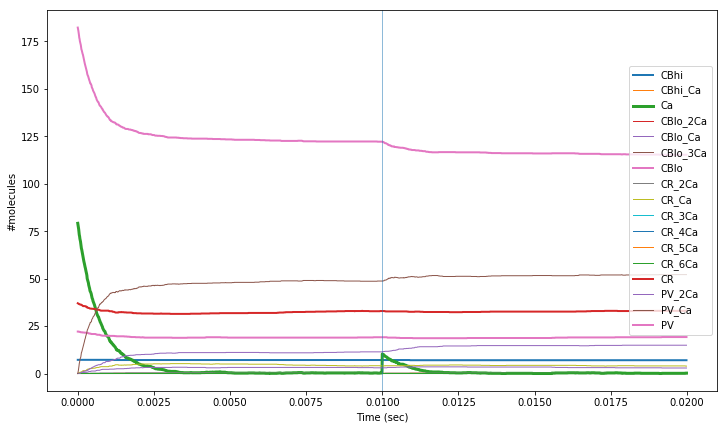

In [60]:
%matplotlib inline
T = 0.02          # sim time
dt = 0.00001      # delta t
Tp = T/2          # This is when Ca2+ invades the terminal

# time vector:
time = np.arange(0, T, dt)

def myround(x, base=dt):
    return base * round(x/base)

# simulate for NITER times every timestep (to smooth out the jitter):
NITER = 10
output = np.zeros([NITER, len(time), sim.getNCompSpecs(0)])


for i in range(0, NITER):
    sim.reset()
    sim = set_init_cond(sim)
    c = 0
    for t in np.arange(0, T, dt):
        sim.run(t)
        if t == myround(Tp, base=dt):
            sim.setCompCount('comp', 'Ca', sim.getCompCount('comp', 'Ca') + 10)
#             sim.setCompReacK('comp','kreac_f', 0.1e6)
#             sim.setCompReacK('comp','kreac_b', 100.7)
        for j in range(sim.getNCompSpecs(0)):
            output[i, c, j] = sim.getCompCount('comp', sim.getCompSpecName(0, j).decode("utf-8"))
        c += 1
out_mean = np.mean(output, axis=0)
plt.figure(figsize=(12,7))
highlight = ['Ca', 'CR', 'CBlo', 'CBhi', 'PV']
for j in range(sim.getNCompSpecs(0)):
    spec_name = sim.getCompSpecName(0, j).decode("utf-8")
    linewidth = 2 if any([spec_name==i for i in highlight]) else 1
    linewidth = 3 if any([spec_name=='Ca']) else linewidth
    plt.plot(time, out_mean[:,j], label = spec_name, linewidth=linewidth)

plt.axvline(x=Tp, linewidth=0.5)
plt.xlabel('Time (sec)')
plt.ylabel('#molecules')
plt.legend(loc='right')
plt.show()

# NOTES
## Molar concentration:
$$ \boxed {c = \frac {N}{N_A V}}$$

## Number of molecules in a volume with a given molar concentration (mol/L):
$$ \boxed {N = C N_A V}$$

$$
N = \frac {mol}{L} \frac {1}{mol} \frac {m^3}{1} = \frac {m^3}{L} = \frac {kL}{L} 
$$

In [28]:
"""
LET'S COMPUTE THE VOLUMES OF THE SYNAPSES BASED ON MOLECULES/SYN AND MOLARITY DATA
"""

from scipy.constants import N_A

#CR
mol = 2.47*10e-6
N = 369
print('Avogadro\'s number: ', N_A)
print('synapse volume: {} m3'.format(N/(mol * N_A * 1000)))
print('synapse volume: {} um3'.format(N/(2.47*10e-6 * N_A * 1000 * 10e-18)))
print('\n\n')

#CB
mol = 1.98*10e-6
N = 296
print('Avogadro\'s number: ', N_A)
print('synapse volume: {} m3'.format(N/(mol * N_A * 1000)))
print('synapse volume: {} um3'.format(N/(mol * N_A * 1000 * 10e-18)))

Avogadro's number:  6.022140857e+23
synapse volume: 2.4807243154559652e-20 m3
synapse volume: 0.0024807243154559653 um3



Avogadro's number:  6.022140857e+23
synapse volume: 2.4824219998305082e-20 m3
synapse volume: 0.002482421999830508 um3


In [13]:
from scipy.constants import N_A
print('Avogadro\'s number: ', N_A)

vol = 1.6667e-21
c1 =  31.4e-6
c2 = 22.3e-6

N1 = c1 * N_A * vol * 1000 # we multiply by the 1000 because concentration is in mol/L, while volume is in m3 (i.e. kL)
N2 = c2 * N_A * vol * 1000 # we multiply by the 1000 because concentration is in mol/L, while volume is in m3 (i.e. kL)

print('{:.1f} molecules in {} cubic meters of volume at concentration of {} mol/L'.format(N1, vol, c1))
print('{:.1f} molecules in {} cubic meters of volume at concentration of {} mol/L'.format(N2, vol, c2))



Avogadro's number:  6.022140857e+23
31.5 molecules in 1.6667e-21 cubic meters of volume at concentration of 3.14e-05 mol/L
22.4 molecules in 1.6667e-21 cubic meters of volume at concentration of 2.23e-05 mol/L


In [60]:
print(sim.getCompReacA('comp','kreac_f'))
print(sim.getCompReacA('comp','kreac_b'))

37.36137539365346
11.899999999999999
